In [2]:
import os
import urllib

# Download the data
API_KEY = "PO6RG0NM9390YF3A"
STOCK_SYMBOL = "SPY"
INTERVAL = "1min"
DATA_TYPE = "MONTHLY" # INTRADAY || DAILY || WEEKLY || MONTHLY

if DATA_TYPE == "intraday":
    DOWNLOAD_ROOT = f"https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={STOCK_SYMBOL}&interval={INTERVAL}&apikey={API_KEY}&datatype=csv&ouputsize=full"
else:
    DOWNLOAD_ROOT = f"https://www.alphavantage.co/query?function=TIME_SERIES_{DATA_TYPE}&symbol={STOCK_SYMBOL}&apikey={API_KEY}&datatype=csv&ouputsize=full"
filename = STOCK_SYMBOL+"_"+DATA_TYPE+".csv"
datapath = "rawdata/"
os.makedirs(datapath, exist_ok=True)
urllib.request.urlretrieve(DOWNLOAD_ROOT, datapath+filename)
print('Download complete.')

Download complete.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime

data = pd.read_csv(datapath + filename, thousands=',')

data = data.iloc[::-1]
print(data)

      timestamp      open      high       low     close      volume
255  1999-12-31  139.3125  147.5625  139.0000  146.8750   121529300
254  2000-01-31  148.2500  148.2500  135.0000  139.5625   156770800
253  2000-02-29  139.7500  144.5625  132.7187  137.4375   186938300
252  2000-03-31  137.6250  155.7500  135.0312  150.3750   247594900
251  2000-04-28  150.1250  153.1093  133.5000  145.0937   229246200
..          ...       ...       ...       ...       ...         ...
4    2020-11-30  330.2000  364.3800  327.2400  362.0600  1534447743
3    2020-12-31  365.5700  378.4600  362.0300  373.8800  1342397107
2    2021-01-29  375.3100  385.8500  364.8200  370.0700  1400691918
1    2021-02-26  373.7200  394.1700  370.3760  380.3600  1297509572
0    2021-03-24  385.5900  398.1200  371.8800  387.5200  1874239307

[256 rows x 6 columns]


In [4]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import pandas as pd
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [5]:
nextClose = []
curOpen = []
curClose = []
curHigh = []
curLow = []
curVol = []
for row in range(len(data['open'])-2):
    curOpen.append(data['open'].iloc[row])
    curClose.append(data['close'].iloc[row])
    curHigh.append(data['high'].iloc[row])
    curLow.append(data['low'].iloc[row])
    curVol.append(data['volume'].iloc[row])
    nextClose.append(data['close'].iloc[row+1])
newData = {'open':curOpen, 'close':curClose, 'high':curHigh, 'low':curLow, 'volume':curVol, 'next_day_close':nextClose}
data = pd.DataFrame(newData)
X = data[['open','close','high','low','volume']]
y = data['next_day_close']
print(data)

         open     close      high       low      volume  next_day_close
0    139.3125  146.8750  147.5625  139.0000   121529300        139.5625
1    148.2500  139.5625  148.2500  135.0000   156770800        137.4375
2    139.7500  137.4375  144.5625  132.7187   186938300        150.3750
3    137.6250  150.3750  155.7500  135.0312   247594900        145.0937
4    150.1250  145.0937  153.1093  133.5000   229246200        142.8125
..        ...       ...       ...       ...         ...             ...
249  350.2100  334.8900  358.7500  319.8000  1815146487        326.5400
250  337.6900  326.5400  354.0200  322.6000  1629408336        362.0600
251  330.2000  362.0600  364.3800  327.2400  1534447743        373.8800
252  365.5700  373.8800  378.4600  362.0300  1342397107        370.0700
253  375.3100  370.0700  385.8500  364.8200  1400691918        380.3600

[254 rows x 6 columns]


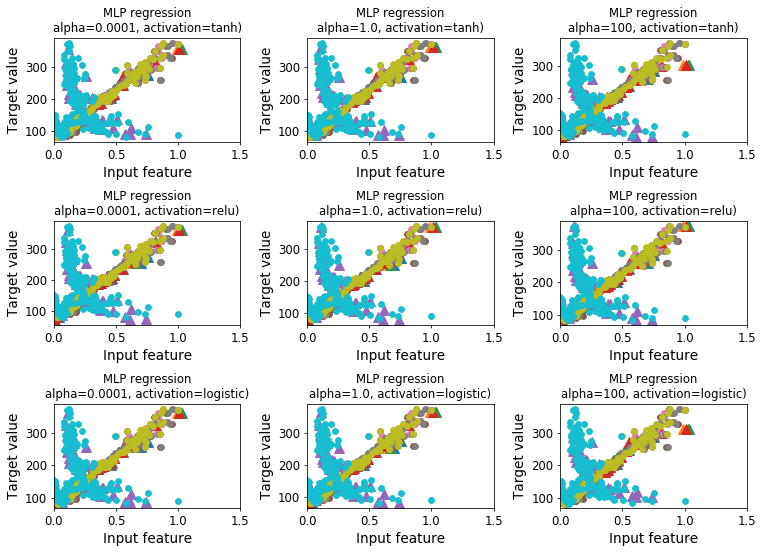

In [6]:
#NO LONGER USELESS STUFF
import warnings
warnings.filterwarnings('ignore')

from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

fig, subaxes = plt.subplots(3, 3, figsize=(11,8), dpi=70)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_predict_input = X_test

for thisaxisrow, thisactivation in zip(subaxes, ['tanh', 'relu', 'logistic']):
    for thisalpha, thisaxis in zip([0.0001, 1.0, 100], thisaxisrow):
        mlpreg = MLPRegressor(hidden_layer_sizes = [100,100],
                             activation = thisactivation,
                             alpha = thisalpha,
                             solver = 'lbfgs').fit(X_train, y_train)
        y_predict_output = mlpreg.predict(X_predict_input)
        thisaxis.set_xlim([0, 1.5])
        thisaxis.plot(X_predict_input, y_predict_output,
                     '^', markersize = 10)
        thisaxis.plot(X_train, y_train, 'o')
        thisaxis.set_xlabel('Input feature')
        thisaxis.set_ylabel('Target value')
        thisaxis.set_title('MLP regression\nalpha={}, activation={})'
                          .format(thisalpha, thisactivation))
        plt.tight_layout()


In [7]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_predict_input = X_test

for thisaxisrow, thisactivation in zip(subaxes, ['tanh', 'relu', 'logistic']):
    for thisalpha, thisaxis in zip([0.0001, 1.0, 100], thisaxisrow):
        mlpreg = MLPRegressor(hidden_layer_sizes = [10,50,70],
                             activation = thisactivation,
                             alpha = thisalpha,
                             solver = 'lbfgs').fit(X_train, y_train)
        y_predict_output = mlpreg.predict(X_predict_input)
        print('Activation: ', thisactivation)
        print('Alpha: ', thisalpha)
        print('R-squared score (training): {:.3f}'.format(mlpreg.score(X_train, y_train)))
        print('R-squared score (test): {:.3f}'.format(mlpreg.score(X_test, y_test)))
        print(' RMSE score (train): {:.3f}'.format(sqrt(mean_squared_error(y_train, mlpreg.predict(X_train)))))
        print('RMSE score (test): {:.3f}\n'.format(sqrt(mean_squared_error(y_test, mlpreg.predict(X_test)))))

Activation:  tanh
Alpha:  0.0001
R-squared score (training): 0.979
R-squared score (test): 0.976
 RMSE score (train): 10.406
RMSE score (test): 9.806

Activation:  tanh
Alpha:  1.0
R-squared score (training): 0.988
R-squared score (test): 0.984
 RMSE score (train): 7.785
RMSE score (test): 8.015

Activation:  tanh
Alpha:  100
R-squared score (training): 0.966
R-squared score (test): 0.961
 RMSE score (train): 13.124
RMSE score (test): 12.580

Activation:  relu
Alpha:  0.0001
R-squared score (training): 0.988
R-squared score (test): 0.988
 RMSE score (train): 7.745
RMSE score (test): 7.068

Activation:  relu
Alpha:  1.0
R-squared score (training): 0.989
R-squared score (test): 0.987
 RMSE score (train): 7.601
RMSE score (test): 7.296

Activation:  relu
Alpha:  100
R-squared score (training): 0.987
R-squared score (test): 0.991
 RMSE score (train): 8.147
RMSE score (test): 6.158

Activation:  logistic
Alpha:  0.0001
R-squared score (training): 0.989
R-squared score (test): 0.987
 RMSE sc

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_predict_input = X_test

for thisaxisrow, thisactivation in zip(subaxes, ['tanh', 'relu', 'logistic']):
    for thisalpha, thisaxis in zip([0.0001, 1.0, 100], thisaxisrow):
        mlpreg = MLPRegressor(hidden_layer_sizes = [100,50],
                             activation = thisactivation,
                             alpha = thisalpha,
                             solver = 'lbfgs').fit(X_train, y_train)
        y_predict_output = mlpreg.predict(X_predict_input)
        print('Activation: ', thisactivation)
        print('Alpha: ', thisalpha)
        print('R-squared score (training): {:.3f}'.format(mlpreg.score(X_train, y_train)))
        print('R-squared score (test): {:.3f}'.format(mlpreg.score(X_test, y_test)))
        print(' RMSE score (train): {:.3f}'.format(sqrt(mean_squared_error(y_train, mlpreg.predict(X_train)))))
        print('RMSE score (test): {:.3f}\n'.format(sqrt(mean_squared_error(y_test, mlpreg.predict(X_test)))))

Activation:  tanh
Alpha:  0.0001
R-squared score (training): 0.947
R-squared score (test): 0.927
 RMSE score (train): 16.417
RMSE score (test): 17.239

Activation:  tanh
Alpha:  1.0
R-squared score (training): 0.988
R-squared score (test): 0.979
 RMSE score (train): 7.732
RMSE score (test): 9.143

Activation:  tanh
Alpha:  100
R-squared score (training): 0.962
R-squared score (test): 0.957
 RMSE score (train): 14.011
RMSE score (test): 13.164

Activation:  relu
Alpha:  0.0001
R-squared score (training): 0.989
R-squared score (test): 0.988
 RMSE score (train): 7.490
RMSE score (test): 6.940

Activation:  relu
Alpha:  1.0
R-squared score (training): 0.989
R-squared score (test): 0.988
 RMSE score (train): 7.581
RMSE score (test): 6.953

Activation:  relu
Alpha:  100
R-squared score (training): 0.986
R-squared score (test): 0.992
 RMSE score (train): 8.546
RMSE score (test): 5.811

Activation:  logistic
Alpha:  0.0001
R-squared score (training): 0.992
R-squared score (test): 0.989
 RMSE s